In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import os
from numba import cuda 
plt.style.use("science.mplstyle")
from sklearn.metrics import roc_auc_score, auc

from helpers.synthesis import *
from helpers.visualization import *


dpi = 800

In [18]:
# fixed 


gen_seed = 1
results_dir = f"/global/ml4hep/spss/rrmastandrea/synth_SM_AD/NF_results_wide_seed_{gen_seed}/"

keys = [ "salad", "cathode", "curtains", "feta", "random"]
keys = ["combined"]

n_sig_inj = [0]

n_seed = 4
num_bkg = 320000
num_sig = 20000

rerun = True

# Load in


In [19]:
process = "None" #StandardScale


n_avg = 1 # number of classifiers to average the scores over
n_trials_post_avg = int(n_seed / n_avg)

# truth labels
y_test = np.concatenate((torch.zeros((num_bkg, 1)), torch.ones((num_sig,1))))

#x_axis = np.logspace(-8, 0, 400)
x_axis = np.linspace(1e-5, 1, 100)

# initialize dictionaries
auc_dict = {k:{n:[] for n in n_sig_inj} for k in keys}


## Calculate AUC

Combination: event level

Working on n_sig = 0...


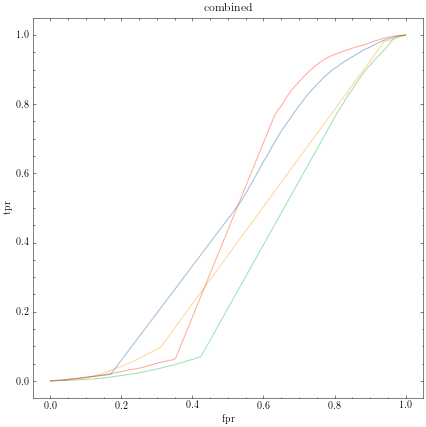

In [20]:
if rerun:
    for n in n_sig_inj:
        
        print(f"Working on n_sig = {n}...")
        
        
        # load in the scores data for a given signal injection
        all_results_bkg, all_results_sig = load_in_data(n, num_bkg, process,
                                                    keys, n_seed, gen_seed, results_dir)
        for k in keys:
            
            plt.figure()
            plt.title(k)
            plt.xlabel("fpr")
            plt.ylabel("tpr")
            
            for seed in range(n_seed):
      
                scores = np.concatenate((all_results_bkg[k][seed], all_results_sig[k][seed]))
                fpr, tpr, _ = roc_curve(y_test, scores)
                plt.plot(fpr, tpr, alpha = 0.4) 
                loc_auc = auc(fpr, tpr)
                if loc_auc < 0.5:
                    loc_auc = 1.0 - loc_auc
                auc_dict[k][n].append(loc_auc)   
                
            plt.show()
            
        

Combination: score-level

Working on n_sig = 0...


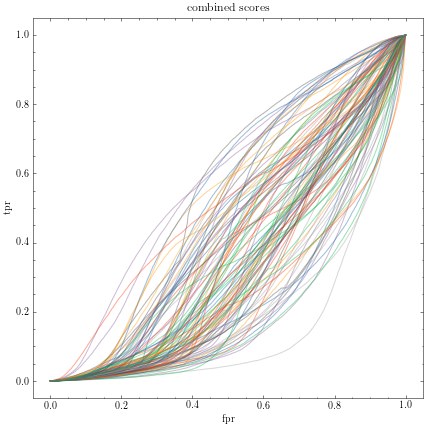

In [10]:
keys_to_avg = [ "salad", "cathode", "curtains", "feta"]


auc_dict["combined_scores"] = {n:[] for n in n_sig_inj}


if rerun:
    
    plt.figure()
    plt.title("combined scores")
    plt.xlabel("fpr")
    plt.ylabel("tpr")
        
    for n in n_sig_inj:
        
        print(f"Working on n_sig = {n}...")
        
        # load in the scores data for a given signal injection
        all_results_bkg, all_results_sig = load_in_data(n, num_bkg, process,
                                                    keys_to_avg, n_seed, gen_seed, results_dir)
        
        
        for seed in range(n_seed):
        
            avg_scores = np.mean([np.concatenate((all_results_bkg[k][seed], all_results_sig[k][seed])) for k in keys_to_avg], axis = 0)
       
            fpr, tpr, _ = roc_curve(y_test, avg_scores)
            plt.plot(fpr, tpr, alpha = 0.4) 
            loc_auc = auc(fpr, tpr)
            if loc_auc < 0.5:
                loc_auc = 1.0 - loc_auc
        
        
            auc_dict["combined_scores"][n].append(loc_auc)  
            
    plt.show()
                

# Take the median / get errorbands

In [21]:
# initialize dictionaries

keys = [ "combined"]

med_aucs_dict = {k:[np.array([]),np.array([]),np.array([])] for k in keys}

for n in n_sig_inj:
    
    for k in keys:
        
        med_aucs_dict[k][0] = np.append(med_aucs_dict[k][0], np.median(auc_dict[k][n]))
        med_aucs_dict[k][1] = np.append(med_aucs_dict[k][1], np.percentile(auc_dict[k][n], 16))
        med_aucs_dict[k][2] = np.append(med_aucs_dict[k][2], np.percentile(auc_dict[k][n], 84))
                        

In [22]:
print(med_aucs_dict)

{'combined': [array([0.56141877]), array([0.5227011]), array([0.62321852])]}


In [23]:
med_aucs_dict = {'salad': [np.array([0.6514204]), np.array([0.55374842]), np.array([0.79956065])], 
                 'cathode': [np.array([0.72160104]), np.array([0.58986338]), np.array([0.7918168])], 
                 'curtains': [np.array([0.67429178]), np.array([0.60883876]), np.array([0.74970646])], 
                 'feta': [np.array([0.59270528]), np.array([0.52073888]), np.array([0.66358])], 
                 'random': [np.array([0.52245746]), np.array([0.50003444]), np.array([0.7491914])],
                 'combined': [np.array([0.56141877]), np.array([00.5227011]), np.array([0.62321852])],
                'combined_scores': [np.array([0.64833068]), np.array([0.54787224]), np.array([0.72126922])]}

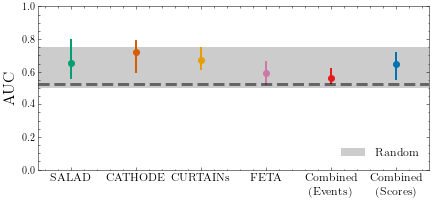

In [26]:
colors_dict = {"full_sup":"grey",
               "salad": "#009E73",
               "feta": "#CC79A7",
               "cathode":"#D55E00",
               "curtains":"#E69F00",
                "combined": "#e41a1c",
               "combined_scores": "#0072B2",
                "ideal_ad":"#56B4E9"}

labels_dict = {"full_sup":"Fully Supervised",
               "salad": "SALAD",
               "feta": "FETA",
               "cathode":"CATHODE",
               "curtains":"CURTAINs",
                "combined": "Combined (Events)",
               "combined_scores": "Combined (Scores)",
              "ideal_ad": "Ideal. AD"}

l = 3
f_1 = 20
f_2 = 30
alpha = 0.4

keys = [ "salad", "cathode", "curtains", "feta", "combined", "combined_scores", "random"]


fig = plt.figure(figsize = (7,3))
  


for i, k in enumerate(keys[:-1]):
    plt.errorbar(i, med_aucs_dict[k][0], 
                 [med_aucs_dict[k][0]-med_aucs_dict[k][1], med_aucs_dict[k][2]-med_aucs_dict[k][0]],
                  marker="o", ls="none", elinewidth=2, markersize = 6, color = colors_dict[k])
    
plt.axhline(med_aucs_dict["random"][0] ,color="k", alpha = 0.5, linewidth = l, linestyle = "dashed")
lower = med_aucs_dict["random"][1]
higher = med_aucs_dict["random"][2]
plt.fill_between([-0.5, 5.5], [lower[0], lower[0]], [higher[0], higher[0]] ,color="k", 
                 label = "Random", alpha = 0.2, linewidth = 0, edgecolor = "none")
    
plt.xticks([0,1,2,3,4,5], ["SALAD","CATHODE","CURTAINs","FETA","Combined\n(Events)","Combined\n(Scores)"], fontsize = 12)
plt.ylabel("AUC", fontsize = 16)
plt.ylim(0,1)

plt.xlim(-.5, 5.5)
dpi = 800 
plt.legend(loc = "lower right", fontsize = 12)
plt.savefig(f'plots/aucs.pdf', facecolor='white', dpi = dpi)

plt.show()